In [2]:
!conda install python-slugify

Fetching package metadata .............
Solving package specifications: .

Package plan for installation in environment /home/tsdataclinic/.conda/envs/dataclinic:

The following NEW packages will be INSTALLED:

    python-slugify: 3.0.3-py_0   
    text-unidecode: 1.2-py35_0   
    unidecode:      1.0.22-py35_0

Proceed ([y]/n)? ^C


In [161]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('/home/vera0519/vera_911')
import pandas as pd
# import cenpy
from slugify import slugify

from pathlib import Path
import src.features.call_types as call_types
from src.cities.new_orleans import NewOrleans
from src.cities.seattle import Seattle
from src.cities.dallas import Dallas
from src.cities.detroit import Detroit
from src.cities.charleston import Charleston
import matplotlib.pyplot as plt
import src.features.geo as Geo
from src.features.call_types import load_call_mappings, assign_disposition, process
import src.visualization.visualize as vis

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
2

2

In [162]:
new_orleans  =  NewOrleans()
dallas  = Dallas()
seattle = Seattle()
detroit = Detroit()
charleston = Charleston()

In [ ]:
# new_orleans.process_data()
# dallas.process_data()
# detroit.process_data()
charleston.process_data()
# seattle.process_data()

procesisng geo for  <src.cities.charleston.Charleston object at 0x7f10945a37f0>
Loading data from local cache
Raw data invert dictionary  {'': 'self_initiated', 'Response_Date': 'call_time', 'Call_Disposition': 'disposition', 'Problem': 'call_type', 'Beat': 'beat'}
No Preprocess script
Reanaming positional columns
Converting Geo units
Generating point geometries


100%|██████████| 708701/708701 [02:05<00:00, 5636.32it/s]


In [47]:
# seattle.process_data()

In [48]:
new_orleans.clean_data(reload=False)
dallas.clean_data(reload=False)
detroit.clean_data(reload=False)
charleston.clean_data(reload=False)
seattle.clean_data(reload=False);

In [49]:
def summary_office_initiated(city):
    return (city.clean_data()
           .groupby(['year','self_initiated'])
           .count()
           .reset_index()
           .pivot_table(index='year', columns='self_initiated', values='day_of_week')
           .assign(total=lambda x: x.sum(axis=1))
           .assign(percent_other = lambda x: 100*x.No/x.total,
                   pecent_self_initaited = lambda x: 100*x.Yes/x.total)
           .rename(columns={'No' : 'other', 'Yes': 'self_initiated'}))
    

In [50]:
def summary_by_type(city):
    return (city.clean_data()
           .loc[lambda x: x.year.isin([2014,2015,2016,2018,2019])]
           .groupby(['year','self_initiated'])
           .count()
           .reset_index()
           .pivot_table(index='year', columns='self_initiated', values='day_of_week')
           .assign(total=lambda x: x.sum(axis=1))
           .assign(percent_other = lambda x: 100*x.No/x.total,
                   pecent_self_initaited = lambda x: 100*x.Yes/x.total)
           .rename(columns={'No' : 'other', 'Yes': 'self_initiated'}))

#            .assign(percent_other = lambda x: 100*x.No/x.total,
#                    pecent_self_initaited = lambda x: 100*x.Yes/x.total)
          # .rename(columns={'No' : 'other', 'Yes': 'self_initiated'}))

In [51]:
def summary_by_type_disposition(city, percentage=False):
    return (city.clean_data()
           .loc[lambda x: x.year.isin([2014,2015,2016,2018,2019])]
           .rename(columns={'year': 'Year', 'call_type': 'Incident Type','disposition':"Disposition"})
           .groupby(['Year','Incident Type','Disposition'])
           .count()[['index']]
           .rename(columns= {'index' : 'Frequency'})
           .reset_index()
           .pivot_table(index=['Year','Incident Type'], columns='Disposition', values='Frequency')
           .fillna(0)
           .pipe(lambda x: 100* x.div(x.sum(axis=1),axis =0 ) if percentage else x)
           .rename(columns = lambda x: "Percent {}".format(x) if percentage else "Frequency {}".format(x))
           )
def full_summary_by_type_disposition(city):
    return pd.merge(
        summary_by_type_disposition(new_orleans, percentage=False),
        summary_by_type_disposition(new_orleans, percentage=True),
        left_index=True,
        right_index=True
    )

In [52]:
def summary_of_priority(city, percentage = False):
    return (city.clean_data()
                .rename(columns= {'year': 'Year', 'priority': 'Priority'})
                .groupby(['Year','Priority'])
                .count()
                [['index']]
                .rename(columns={'index': 'Frequency'})
                .reset_index()
                .pivot_table(index='Year', columns='Priority',values='Frequency')
                .pipe(lambda x: 100* x.div(x.sum(axis=1),axis =0 ) if percentage else x)
                .fillna(0)
                .rename(columns = lambda x: "Percent {}".format(x) if percentage else "Frequency {}".format(x))
                
           )


## Generate reports

City Priorty Breakdown

In [33]:
with pd.ExcelWriter('../../reports/CityPriorityBreakdown.xlsx') as writer:
    summary_of_priority(new_orleans).to_excel(writer,sheet_name='New Orleans')
#     summary_of_priority(dallas).to_excel(writer,sheet_name='Dallas')
    summary_of_priority(detroit).to_excel(writer,sheet_name='Detroit')
    summary_of_priority(seattle).to_excel(writer,sheet_name='Seattle')
#     summary_of_priority(charleston).to_excel(writer,sheet_name='Charleston')


City Call Type Disposition 

In [34]:
with pd.ExcelWriter('../../reports/CityCallTypeDisposition.xlsx') as writer:
    full_summary_by_type_disposition(new_orleans).to_excel(writer,sheet_name='New Orleans')
    full_summary_by_type_disposition(dallas).to_excel(writer,sheet_name='Dallas')
    full_summary_by_type_disposition(detroit).to_excel(writer,sheet_name='Detroit')
    full_summary_by_type_disposition(charleston).to_excel(writer,sheet_name='Charleston')
    full_summary_by_type_disposition(seattle).to_excel(writer, sheet_name='Seattle')
    #     for worksheet in writer.sheets:
#         for i in range(10):
#             worksheet.set_column(i,i,15)
    
    

City Officer Initiated Summary 

In [35]:
with pd.ExcelWriter('../../reports/CityOfficerInitiatedSummary.xlsx') as writer:
    summary_office_initiated(new_orleans).to_excel(writer,sheet_name='New Orleans', merge_cells=False)
#     summary_office_initiated(dallas).to_excel(writer,sheet_name='Dallas')
    summary_office_initiated(detroit).to_excel(writer,sheet_name='Detroit', merge_cells=False)
    summary_office_initiated(seattle).to_excel(writer,sheet_name='Seattle')
#     summary_office_initiated(charleston).to_excel(writer,sheet_name='Charleston')

Call Type summary

In [36]:
with pd.ExcelWriter('../../reports/CityCallTypeSummary.xlsx') as writer:
    summary_by_type(new_orleans).to_excel(writer,sheet_name='New Orleans')
#     summary_by_type(dallas).to_excel(writer,sheet_name='Dallas')
    summary_by_type(detroit).to_excel(writer,sheet_name='Detroit')
    summary_by_type(seattle).to_excel(writer,sheet_name='Seattle')
#     summary_by_type(charleston).to_excel(writer,sheet_name='Charleston')

## Generate Plots

In [13]:
import matplotlib.pyplot as plt 
%matplotlib inline

In [49]:
import geopandas as gp

In [50]:
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [67]:
map_crs= {'init':'epsg:3857'}
from matplotlib.font_manager import FontProperties
fontP = FontProperties()
fontP.set_size('xx-large')


def map_call_volume(city,norm_by=None, ax=None, year=None, call_type=None,scheme=None, vrange=None):
    if(not ax):
        fig = plt.figure()
        ax = fig.add_subplot(111)
    data = city.call_volume_by_tract(norm_by='capita',year=year, call_type=call_type)
    if(vrange):
        data.to_crs(map_crs).plot(column='calls', legend=True,ax=ax, scheme=scheme, vmin=vrange[0],vmax=vrange[1], legend_kwds={ 'loc': "lower center"}) 
    else:
        data.to_crs(map_crs).plot(column='calls', legend=True,ax=ax, scheme=scheme,legend_kwds={ 'loc': "best", "bbox_to_anchor":(1.35,1),'fontsize':'xx-large','title':'Calls per capita'} )
    ax.set_title('Calls per capita')
    ax.legend(title_fontsizve='xx-large')
    ax.set_axis_off()
    return ax 

[19:41:20.499 WARNING] /home/tsdataclinic/.conda/envs/dataclinic/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "



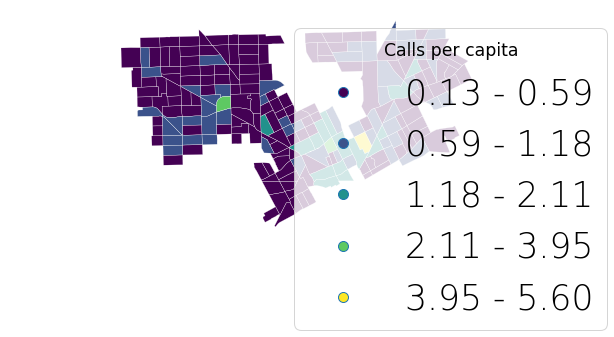

In [119]:
city = detroit
tracts = city.load_tracts().to_crs(vis.map_crs)
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
map_call_volume(city, norm_by='capita', ax=ax, scheme='fisher_jenks')
leg_kwds_dict={'fontsize':'xx-large'}
tracts.plot(color='none', edgecolor='white', ax=ax, linewidth=0.2, legend_kwds=leg_kwds_dict)
ax.set_title("")
plt.tight_layout()

leg = ax.get_legend()
leg.set_title('Calls per capita',prop = fontP )

In [ ]:
BASE_MAP_DIR = Path('/home/vera0519/vera_911/reports/VeraExport/Maps')

def generate_per_capita_maps(geometry='tract'):
    plot_dir = BASE_MAP_DIR / "call_volumne_per_capita"
    plot_dir.mkdir(exist_ok=True)
    figsize = (10,10)
    for city in [new_orleans,dallas,detroit,charleston]:
        
        tracts = city.load_tracts().to_crs(vis.map_crs)
        
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111)
        vis.map_call_volume(city, norm_by='capita', ax=ax, scheme='percentiles')
        tracts.plot(color='none', edgecolor='red', ax=ax)
        fig.savefig(plot_dir / '{}-{}-tracts-all_years-all_CFS.png'.format(city.BASE_NAME, 'calls_per_capita'))
        
        for year in city.USE_YEARS:
            fig = plt.figure(figsize=figsize)
            ax = fig.add_subplot(111)
            vis.map_call_volume(city, norm_by='capita', ax=ax, scheme='percentiles',year=year)
            tracts.plot(facecolor='none', edgecolor='black', ax=ax)
            ax.set_title('{} / calls per capita / {} / {}'.format(city.BASE_NAME, 'All Years', 'All CFS'))
            fig.savefig(plot_dir / '{}-{}-tracts-{}-all_CFS.png'.format(city.BASE_NAME, 'calls_per_capita',year))
            
        for year in city.USE_YEARS:
            fig = plt.figure(figsize=figsize)
            ax = fig.add_subplot(111)
            vis.map_call_volume(city, norm_by='capita', ax=ax, scheme='percentiles',year=year)
            ax.set_title('{} / calls per capita / {} / {}'.format(city.BASE_NAME, year, 'All CFS'))
            tracts.plot(facecolor='none', edgecolor='black', ax=ax)
            fig.savefig(plot_dir / '{}-{}-tracts-{}-all_CFS.png'.format(city.BASE_NAME, 'calls_per_capita',year))
            
        for cfs in city.clean_data().call_type.unique():
            if(cfs != None):
                fig = plt.figure(figsize=figsize)
                ax = fig.add_subplot(111)
                vis.map_call_volume(city, norm_by='capita', ax=ax, scheme='percentiles',call_type=cfs)
                ax.set_title('{} / calls per capita / {} / {}'.format(city.BASE_NAME, 'All Years', cfs))
                tracts.plot(facecolor='none', edgecolor='black', ax=ax)
                fig.savefig(plot_dir / '{}-{}-tracts-all_years-{}.png'.format(city.BASE_NAME, 'calls_per_capita',slugify(cfs)))
        
        for year  in city.USE_YEARS:
            for cfs in city.clean_data().call_type.unique():
                if(cfs != None):
                    fig = plt.figure(figsize=figsize)
                    ax = fig.add_subplot(111)
                    vis.map_call_volume(city, norm_by='capita', ax=ax, scheme='percentiles',year=year,call_type=cfs)
                    ax.set_title('{} / calls per capita / {} / {}'.format(city.BASE_NAME, year, cfs))
                    tracts.plot(facecolor='none', edgecolor='black', ax=ax)
                    fig.savefig(plot_dir / '{}-{}-tracts-all_years-{}.png'.format(city.BASE_NAME,'calls_per_capita',slugify(cfs)))
    
# def generate_disposition_maps(geometry='tract'):
#     vis.plot_disposition_counts
    
# def generate_response_time_maps(geometry='tract'):
#     vis.map_median_response_time
    
# def generate_demographic_maps(geometry='tract'):
#     vis.demgraphics()

generate_per_capita_maps();

In [ ]:
def generate_self_initiated_fraction_maps(geometry='tract'):
    plot_dir = BASE_MAP_DIR / "officer_initiated"
    plot_dir.mkdir(exist_ok=True)
    figsize = (10,10)
    for city in [new_orleans,dallas,detroit,charleston]:
        
        tracts = city.load_tracts().to_crs(vis.map_crs)
        
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111)
        vis.map_self_initiated(city, norm_by='total', ax=ax)
        tracts.plot(color='none', edgecolor='black', ax=ax)
        fig.savefig(plot_dir / '{}-{}-tracts-all_years-all_CFS.png'.format(city.BASE_NAME, 'officer_initiated_fraction'))
        
        for year in city.USE_YEARS:
            fig = plt.figure(figsize=figsize)
            ax = fig.add_subplot(111)
            vis.map_self_initiated(city, norm_by='total', ax=ax, year=year)
            tracts.plot(facecolor='none', edgecolor='black', ax=ax)
            ax.set_title('{} / officer initiated fraction / {} / {}'.format(city.BASE_NAME, 'All Years', 'All CFS'))
            fig.savefig(plot_dir / '{}-{}-tracts-{}-all_CFS.png'.format(city.BASE_NAME, 'officer_initiated_fraction',year))
            
        for year in city.USE_YEARS:
            fig = plt.figure(figsize=figsize)
            ax = fig.add_subplot(111)
            vis.map_self_initiated(city, norm_by='total', ax=ax,year=year)
            ax.set_title('{} / officer initiated fraction / {} / {}'.format(city.BASE_NAME, year, 'All CFS'))
            tracts.plot(facecolor='none', edgecolor='black', ax=ax)
            fig.savefig(plot_dir / '{}-{}-tracts-{}-all_CFS.png'.format(city.BASE_NAME, 'officer_initiated_fraction',year))
            
        for cfs in city.clean_data().call_type.unique():
            if(cfs != None):
                fig = plt.figure(figsize=figsize)
                ax = fig.add_subplot(111)
                vis.map_self_initiated(city, norm_by='total', ax=ax,call_type=cfs)
                ax.set_title('{} / officer initiated fraction / {} / {}'.format(city.BASE_NAME, 'All Years', cfs))
                tracts.plot(facecolor='none', edgecolor='black', ax=ax)
                fig.savefig(plot_dir / '{}-{}-tracts-all_years-{}.png'.format(city.BASE_NAME, 'officer_initiated_fraction',slugify(cfs)))
        
        for year  in city.USE_YEARS:
            for cfs in city.clean_data().call_type.unique():
                if(cfs != None):
                    fig = plt.figure(figsize=figsize)
                    ax = fig.add_subplot(111)
                    vis.map_self_initiated(city, norm_by='total', ax=ax,year=year,call_type=cfs)
                    ax.set_title('{} / officer initiated fraction / {} / {}'.format(city.BASE_NAME, year, cfs))
                    tracts.plot(facecolor='none', edgecolor='black', ax=ax)
                    fig.savefig(plot_dir / '{}-{}-tracts-all_years-{}.png'.format(city.BASE_NAME,'officer_initiated_fraction',slugify(cfs)))
generate_self_initiated_fraction_maps();

In [ ]:
def generate_enforcement_action_maps(geometry='tract'):
    plot_dir = BASE_MAP_DIR / "enforcement_action"
    plot_dir.mkdir(exist_ok=True)
    figsize = (10,10)
    for city in [new_orleans,dallas,detroit,charleston]:
        
        tracts = city.load_tracts().to_crs(vis.map_crs)
        
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111)
        vis.map_enforcement_by_tract(city, ax=ax)
        tracts.plot(color='none', edgecolor='black', ax=ax)
        fig.savefig(plot_dir / '{}-{}-tracts-all_years-all_CFS.png'.format(city.BASE_NAME, 'enforcement_action'))
        
        for year in city.USE_YEARS:
            fig = plt.figure(figsize=figsize)
            ax = fig.add_subplot(111)
            vis.map_enforcement_by_tract(city, ax=ax, year=year)
            tracts.plot(facecolor='none', edgecolor='black', ax=ax)
            ax.set_title('{} / Enforcement Action / {} / {}'.format(city.BASE_NAME, 'All Years', 'All CFS'))
            fig.savefig(plot_dir / '{}-{}-tracts-{}-all_CFS.png'.format(city.BASE_NAME, 'enforcement_action',year))
            
        for year in city.USE_YEARS:
            fig = plt.figure(figsize=figsize)
            ax = fig.add_subplot(111)
            vis.map_enforcement_by_tract(city, ax=ax,year=year)
            ax.set_title('{} / Enforcement Action / {} / {}'.format(city.BASE_NAME, year, 'All CFS'))
            tracts.plot(facecolor='none', edgecolor='black', ax=ax)
            fig.savefig(plot_dir / '{}-{}-tracts-{}-all_CFS.png'.format(city.BASE_NAME, 'enforcement_action',year))
            
        for cfs in city.clean_data().call_type.unique():
            if(cfs != None):
                fig = plt.figure(figsize=figsize)
                ax = fig.add_subplot(111)
                vis.map_enforcement_by_tract(city,  ax=ax,call_type=cfs)
                ax.set_title('{} / Enforcement Action / {} / {}'.format(city.BASE_NAME, 'All Years', cfs))
                tracts.plot(facecolor='none', edgecolor='black', ax=ax)
                fig.savefig(plot_dir / '{}-{}-tracts-all_years-{}.png'.format(city.BASE_NAME, 'enforcement_action',slugify(cfs)))
        
        for year  in city.USE_YEARS:
            for cfs in city.clean_data().call_type.unique():
                if(cfs != None):
                    fig = plt.figure(figsize=figsize)
                    ax = fig.add_subplot(111)
                    vis.map_enforcement_by_tract(city,  ax=ax,year=year,call_type=cfs)
                    ax.set_title('{} / Enforcement Action / {} / {}'.format(city.BASE_NAME, year, cfs))
                    tracts.plot(facecolor='none', edgecolor='black', ax=ax)
                    fig.savefig(plot_dir / '{}-{}-tracts-all_years-{}.png'.format(city.BASE_NAME,'enforcement_action',slugify(cfs)))
generate_enforcement_action_maps();

In [ ]:
def generate_response_time_maps(geometry='tract'):
    plot_dir = BASE_MAP_DIR / "median_response_time"
    plot_dir.mkdir(exist_ok=True)
    figsize = (10,10)
    for city in [new_orleans,dallas,detroit,charleston]:
        
        tracts = city.load_tracts().to_crs(vis.map_crs)
        
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111)
        vis.map_median_response_time(city, ax=ax)
        tracts.plot(color='none', edgecolor='black', ax=ax, scheme='percentiles')
        fig.savefig(plot_dir / '{}-{}-tracts-all_years-all_CFS.png'.format(city.BASE_NAME, 'median_response_time'))
        
        for year in city.USE_YEARS:
            fig = plt.figure(figsize=figsize)
            ax = fig.add_subplot(111)
            vis.map_median_response_time(city, ax=ax, year=year, scheme='percentiles')
            tracts.plot(facecolor='none', edgecolor='black', ax=ax)
            ax.set_title('{} / Median Response Time / {} / {}'.format(city.BASE_NAME, 'All Years', 'All CFS'))
            fig.savefig(plot_dir / '{}-{}-tracts-{}-all_CFS.png'.format(city.BASE_NAME, 'median_response_time',year))
            
        for year in city.USE_YEARS:
            fig = plt.figure(figsize=figsize)
            ax = fig.add_subplot(111)
            vis.map_median_response_time(city, ax=ax,year=year, scheme='percentiles')
            ax.set_title('{} / Median Response Time / {} / {}'.format(city.BASE_NAME, year, 'All CFS'))
            tracts.plot(facecolor='none', edgecolor='black', ax=ax)
            fig.savefig(plot_dir / '{}-{}-tracts-{}-all_CFS.png'.format(city.BASE_NAME, 'median_response_time',year))
            
        for cfs in city.clean_data().call_type.unique():
            if(cfs != None):
                fig = plt.figure(figsize=figsize)
                ax = fig.add_subplot(111)
                vis.map_median_response_time(city,  ax=ax,call_type=cfs, scheme='percentiles')
                ax.set_title('{} / Median Response Time / {} / {}'.format(city.BASE_NAME, 'All Years', cfs))
                tracts.plot(facecolor='none', edgecolor='black', ax=ax)
                fig.savefig(plot_dir / '{}-{}-tracts-all_years-{}.png'.format(city.BASE_NAME, 'median_response_time',slugify(cfs)))
        
        for year  in city.USE_YEARS:
            for cfs in city.clean_data().call_type.unique():
                if(cfs != None):
                    fig = plt.figure(figsize=figsize)
                    ax = fig.add_subplot(111)
                    vis.map_median_response_time(city,  ax=ax,year=year,call_type=cfs, scheme='percentiles')
                    ax.set_title('{} / Median Response Time / {} / {}'.format(city.BASE_NAME, year, cfs))
                    tracts.plot(facecolor='none', edgecolor='black', ax=ax)
                    fig.savefig(plot_dir / '{}-{}-tracts-all_years-{}.png'.format(city.BASE_NAME,'median_response_time',slugify(cfs)))
generate_response_time_maps();

In [8]:
BASE_CHARTS_DIR = Path('/home/vera0519/vera_911/reports/VeraExport/Charts')

def generate_CFS_breakdown():
    plot_dir = BASE_CHARTS_DIR / 'CFS_breakdown'
    plot_dir.mkdir(exist_ok=True)
    figsize=(10,10)
    for city in [new_orleans,dallas,detroit,charleston,seattle]:
        print('Doint city {}'.format(city.BASE_NAME))
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111)
        vis.plot_cfs_breakdown(city)
        fig.savefig(plot_dir / '{}-{}.png'.format(city.BASE_NAME, 'cfs_breakdown'))
        
        for year in city.USE_YEARS:
            fig = plt.figure(figsize=figsize)
            ax = fig.add_subplot(111)
            vis.plot_cfs_breakdown(city,year=year)
            fig.savefig(plot_dir / '{}-{}-{}.png'.format(city.BASE_NAME, 'cfs_breakdown',year))
# generate_CFS_breakdown()
     
# def generate_call_type_by_CFS():
#    vis.plot_self_initated_by_call_type
# def generate_response_time():
#     plot_response_time_dist
    

#     vis.plot_disposition_fraction_by_call_Type(city)


# def generate_top_bottom_breakdown_type_disposition():
    

In [ ]:
def generate_disposition_by_CFS():
    plot_dir = BASE_CHARTS_DIR / 'disposition_by_CFS'
    plot_dir.mkdir(exist_ok=True)
    figsize=(15,10)

    for city in [new_orleans,dallas,detroit,charleston,seattle]:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111)
        vis.plot_disposition_fraction_by_call_Type(city, ax=ax)
        ax.set_xlim(0,1)
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        ax.set_title('{} - {}'.format(city.BASE_NAME,'All Years'))
        plt.tight_layout()
        fig.savefig(plot_dir / '{}-{}.png'.format(city.BASE_NAME, 'disposition_by_CFS'))

        for year in city.USE_YEARS:
            fig = plt.figure(figsize=figsize)
            ax = fig.add_subplot(111)
            vis.plot_disposition_fraction_by_call_Type(city, ax=ax, year=year)
            ax.set_xlim(0,1)
            ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
            ax.set_title('{} - {}'.format(city.BASE_NAME,year))
            plt.tight_layout()
            fig.savefig(plot_dir / '{}-{}-{}.png'.format(city.BASE_NAME, 'disposition_by_CFS',year))
            
generate_disposition_by_CFS()

In [ ]:
def generate_response_time_by_CFS():
    plot_dir = BASE_CHARTS_DIR / 'response_time'
    plot_dir.mkdir(exist_ok=True)
    figsize=(15,10)

    for city in [new_orleans,dallas,detroit,charleston,seattle]:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111)
        vis.plot_response_time_dist(city, ax=ax)
        ax.set_title('{} - {}'.format(city.BASE_NAME,'All Years'))
        fig.savefig(plot_dir / '{}-{}.png'.format(city.BASE_NAME, 'response_time'))

        for year in city.USE_YEARS:
            fig = plt.figure(figsize=figsize)
            ax = fig.add_subplot(111)
            vis.plot_response_time_dist(city, ax=ax, year=year)
            ax.set_title('{} - {} - {} - {}'.format(city.BASE_NAME,'response_time',year, 'All CFS'))
            fig.savefig(plot_dir / '{}-{}-{}-{}.png'.format(city.BASE_NAME, 'response_time',year,'All CFS'))
        
        for cfs in city.clean_data().call_type.unique():
            if(cfs != None):
                fig = plt.figure(figsize=figsize)
                ax = fig.add_subplot(111)
                vis.plot_response_time_dist(city, ax=ax, call_type=cfs)
                ax.set_title('{} - {} - {} - {}'.format(city.BASE_NAME,'response_time','All Years', cfs))
                fig.savefig(plot_dir / '{}-{}-{}-{}.png'.format(city.BASE_NAME, 'response_time','all_years',slugify(cfs)))

        for year in city.USE_YEARS:
            for cfs in city.clean_data().call_type.unique():
                if(cfs != None):
                    fig = plt.figure(figsize=figsize)
                    ax = fig.add_subplot(111)
                    vis.plot_response_time_dist(city, ax=ax, year=year)
                    ax.set_title('{} - {} - {} - {}'.format(city.BASE_NAME,'response_time',year, cfs))
                    fig.savefig(plot_dir / '{}-{}-{}-{}.png'.format(city.BASE_NAME, 'response_time',year,slugify(cfs)))
generate_disposition_by_CFS()

In [ ]:
def self_initiated_by_CFS():
    plot_dir = BASE_CHARTS_DIR / 'officer_initiated_by_CFS'
    plot_dir.mkdir(exist_ok=True)
    figsize=(15,10)

    for city in [new_orleans,dallas,detroit,charleston,seattle]:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111)
        vis.plot_self_initated_by_call_type(city, ax=ax)
        ax.set_xlim(0,1)
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        ax.set_title('{} - {}'.format(city.BASE_NAME,'All Years'))
        plt.tight_layout()
        fig.savefig(plot_dir / '{}-{}.png'.format(city.BASE_NAME, 'officer_initiated_by_CFS'))

        for year in city.USE_YEARS:
            fig = plt.figure(figsize=figsize)
            ax = fig.add_subplot(111)
            vis.plot_self_initated_by_call_type(city, ax=ax, year=year)
            ax.set_xlim(0,1)
            ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
            ax.set_title('{} - {}'.format(city.BASE_NAME,year))
            plt.tight_layout()
            fig.savefig(plot_dir / '{}-{}-{}.png'.format(city.BASE_NAME, 'officer_initiated_by_CFS',year))
            
self_initiated_by_CFS()

In [11]:
def call_type_breakdown_by_quantile(data, variable, quantile_range, ax=None, subset=None ):
    
    try:
        agg = (data[ 
                (data[variable] > data[variable].quantile(quantile_range[0])) & (data[variable] < data[variable].quantile(quantile_range[1])) 
         ]
         .groupby('call_type')
         .count()[['index']]
         .assign(total = lambda x : x['index'].sum())
         .pipe(lambda x: 100*x.div(x.total,axis=0))
         ['index'].sort_values()
        )
        return agg.plot(kind='barh',ax=ax)
    except:
        ax.text(0.5,0.5,'No data', horizontalalignment='center', verticalalignment='center')
        ax.set_axis_off()
        return ax
    
def call_type_breakdown_by_quantile_percent(data,variable,breakdown, quantile_range,ax=None, subset=None):
    try:
        ax = (data[ 
                (data[variable] > data[variable].quantile(quantile_range[0])) & (data[variable] < data[variable].quantile(quantile_range[1])) 
         ]
         .groupby(['call_type', breakdown])
         .count()[['index']]
         .reset_index()
         .pivot_table(index='call_type', values='index', columns=breakdown)
         .assign(total = lambda x: x.sum(axis=1))
         .sort_values(by='total')
         .pipe(lambda x: 100*x.div(x.total,axis=0))
         .drop('total', axis=1)

         .plot(kind='barh', stacked=True,ax=ax)
    #      .assign(total = lambda x : x['index'].sum())
    #      ['index'].sort_values().plot(kind='barh')
        )
        return ax
    except:
        ax.text(0.5,0.5,'No data', horizontalalignment='center', verticalalignment='center')
        ax.set_axis_off()
        return ax

subset = ['Violent Crime','Suspicion','Drugs','Sex Offenses', 'Domestic Violence', 'Property Crime ']

def plot_demographic_breakdown_summary(city,variable,year=None):
    fig, axs= plt.subplots(nrows=3,ncols=2, sharey='row', figsize=(20,15))
    data = (city.filter_calls_by(year=year)
               .pipe(city.assign_demographics))
    data = data[data.call_type.isin(subset)]
    axs= axs.flatten()
    
    call_type_breakdown_by_quantile(data, variable, quantile_range=[0,0.1],ax=axs[0], subset=subset)
    axs[0].set_xlim(0,8.5)
    axs[0].set_title('Lowest 10% of tracts by median income')
    axs[0].set_xlabel('')
    axs[0].set_ylabel('')

    call_type_breakdown_by_quantile_percent(data, variable, 'self_initiated', [0,0.1],ax=axs[2], subset=subset)
    axs[2].set_xlim(0,100)
    axs[2].set_xlabel('% of CFS type by officer initiated')
    axs[2].set_ylabel('')
    axs[2].set_title('')
    axs[2].get_legend().remove()

    call_type_breakdown_by_quantile_percent(data, variable, 'disposition', [0,0.1],ax=axs[4], subset=subset)
    axs[4].set_xlim(0,100)
    axs[4].set_xlabel('% of CFS type by disposition')
    axs[4].set_ylabel('')
    axs[4].set_title('')
    axs[4].get_legend().remove()

    call_type_breakdown_by_quantile(data, variable, quantile_range=[0.9,1.0],ax=axs[1], subset=subset)
    axs[1].set_xlim(0,8.5)
    axs[1].set_title('Highest 10% of tracts by median income')
#     axs[1].set_xlabel('')
    axs[1].set_xlabel('highest 10% of tracts by median income')
    
    max_x = max(axs[1].get_xlim()[1], axs[0].get_xlim()[0])
    axs[0].set_xlim(0,max_x)
    axs[1].set_xlim(0,max_x)

    call_type_breakdown_by_quantile_percent(data, variable, 'self_initiated', [0.9,1.0],ax=axs[3], subset=subset)
    axs[3].set_xlim(0,100)
    axs[3].set_ylabel('')
    axs[3].legend(loc='upper right',title='',bbox_to_anchor=(1.25,1.0), labels=["Other", 'Officer Initiated'])

    call_type_breakdown_by_quantile_percent(data, variable, 'disposition', [0.9,1.0],ax=axs[5], subset=subset)
    axs[5].set_xlim(0,100)
    axs[5].set_ylabel('')
    axs[5].legend(loc='upper right', title='',bbox_to_anchor=(1.3,1.0),fontsize='x-large')
    
    
    plt.suptitle("{} - {} - {}".format(city.BASE_NAME, variable,year if year else  'All Years'))
    plt.tight_layout()
   
   # fig.savefig(path / "{}-{}-{}-{}.png".format(city.BASE_NAME,'demographic_quantiles',variable,year if year else  'All Years'))

In [80]:
import matplotlib

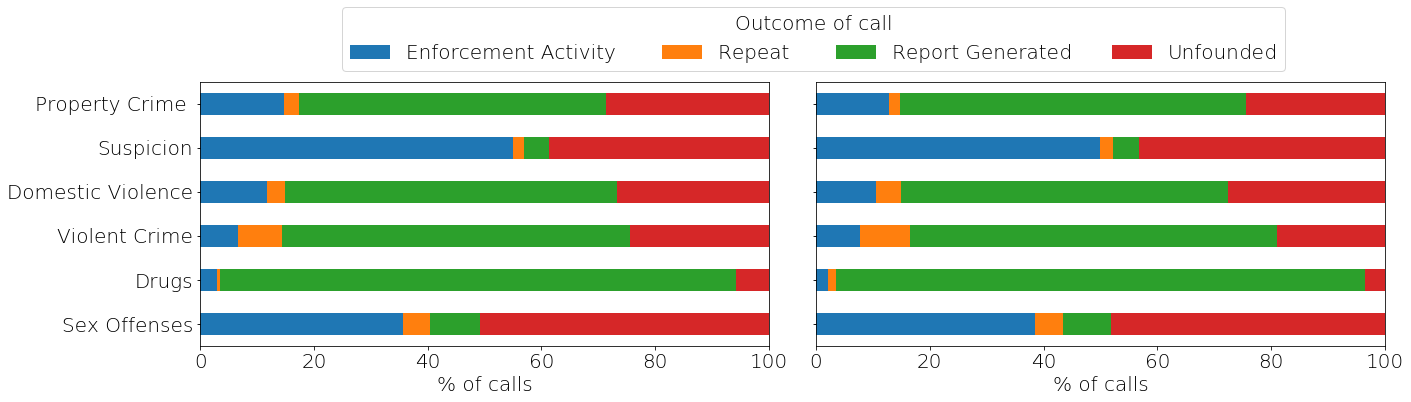

In [118]:
city= new_orleans
variable ='median_income'
year=None

matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

font = {'family' : 'DejaVu Sans',
        'weight' : 'light',
        'size'   : 20}

matplotlib.rc('font', **font)
# fig, axs= plt.subplots(nrows=1,ncols=2, sharey='row', figsize=(20,5))
# data = (city.filter_calls_by(year=year)
#            .pipe(city.assign_demographics))
# data = data[data.call_type.isin(subset)]
# axs= axs.flatten()

# call_type_breakdown_by_quantile(data, variable, quantile_range=[0,0.1],ax=axs[0], subset=subset)
# axs[0].set_xlim(0,8.5)
# axs[0].set_title('Lowest 10% median income',   fontdict={'size': 20, 'weight':'normal'})
# axs[0].set_xlabel('% of total calls', fontdict={'weight':'light'})
# axs[0].set_ylabel('')

# call_type_breakdown_by_quantile(data, variable, quantile_range=[0.9,1.0],ax=axs[1], subset=subset)
# axs[1].set_xlim(0,8.5)
# axs[1].set_title('Highest 10% median income', fontdict={'size': 20, 'weight':'normal'})
# #     axs[1].set_xlabel('')
# axs[1].set_xlabel('% of calls', fontdict={'weight':'light'})

# max_x = max(axs[1].get_xlim()[1], axs[0].get_xlim()[0])
# axs[0].set_xlim(0,max_x)
# axs[1].set_xlim(0,max_x)
# plt.tight_layout()

# fig, axs= plt.subplots(nrows=1,ncols=2, sharey='row', figsize=(20,5))

# axs= axs.flatten()

# call_type_breakdown_by_quantile_percent(data, variable, 'self_initiated', [0,0.1],ax=axs[0], subset=subset)
# axs[0].set_xlim(0,100)
# axs[0].set_xlabel('% of calls', fontdict={'weight':'light'})
# axs[0].set_ylabel('')
# axs[0].set_title('')
# axs[0].get_legend().remove()

# call_type_breakdown_by_quantile_percent(data, variable, 'self_initiated', [0.9,1.0],ax=axs[1], subset=subset)
# axs[1].set_xlim(0,100)
# axs[1].set_xlabel('% of calls', fontdict={'weight':'light'})
# axs[1].set_ylabel('Reason for call',fontdict={'weight':'light'})
# # axs[1].legend(loc='upper right',title='',bbox_to_anchor=(1.25,1.0), labels=["Other", 'Officer Initiated'])
# axs[1].legend(loc='upper center', ncol=2, bbox_to_anchor=(0,1.3) ,title='Officer Initiated')

# plt.tight_layout()

fig, axs= plt.subplots(nrows=1,ncols=2, sharey='row', figsize=(20,5))
axs= axs.flatten()

call_type_breakdown_by_quantile_percent(data, variable, 'disposition', [0,0.1],ax=axs[0], subset=subset)
axs[0].set_xlim(0,100)
axs[0].set_xlabel('% of calls', fontdict={'weight':'light'})
axs[0].set_ylabel('')
axs[0].set_title('')
axs[0].get_legend().remove()



call_type_breakdown_by_quantile_percent(data, variable, 'disposition', [0.9,1.0],ax=axs[1], subset=subset)
axs[1].set_xlim(0,100)
axs[1].set_xlabel('% of calls',fontdict={'weight':'light'})
axs[1].set_ylabel('')
# axs[1].legend(loc='upper right', title='',bbox_to_anchor=(1.25,1.0))
axs[1].legend(loc='upper center', ncol=5, bbox_to_anchor=(-0.004,1.32), title='Outcome of call')


# plt.suptitle("{} - {} - {}".format(city.BASE_NAME, variable,year if year else  'All Years'))
plt.tight_layout()
   

In [ ]:
plot_demographic_breakdown_summary(new_orleans,'median_income')

In [ ]:
2

B23025_004E    float64
B23025_002E    float64
dtype: object


ValueError: left cannot be >= right

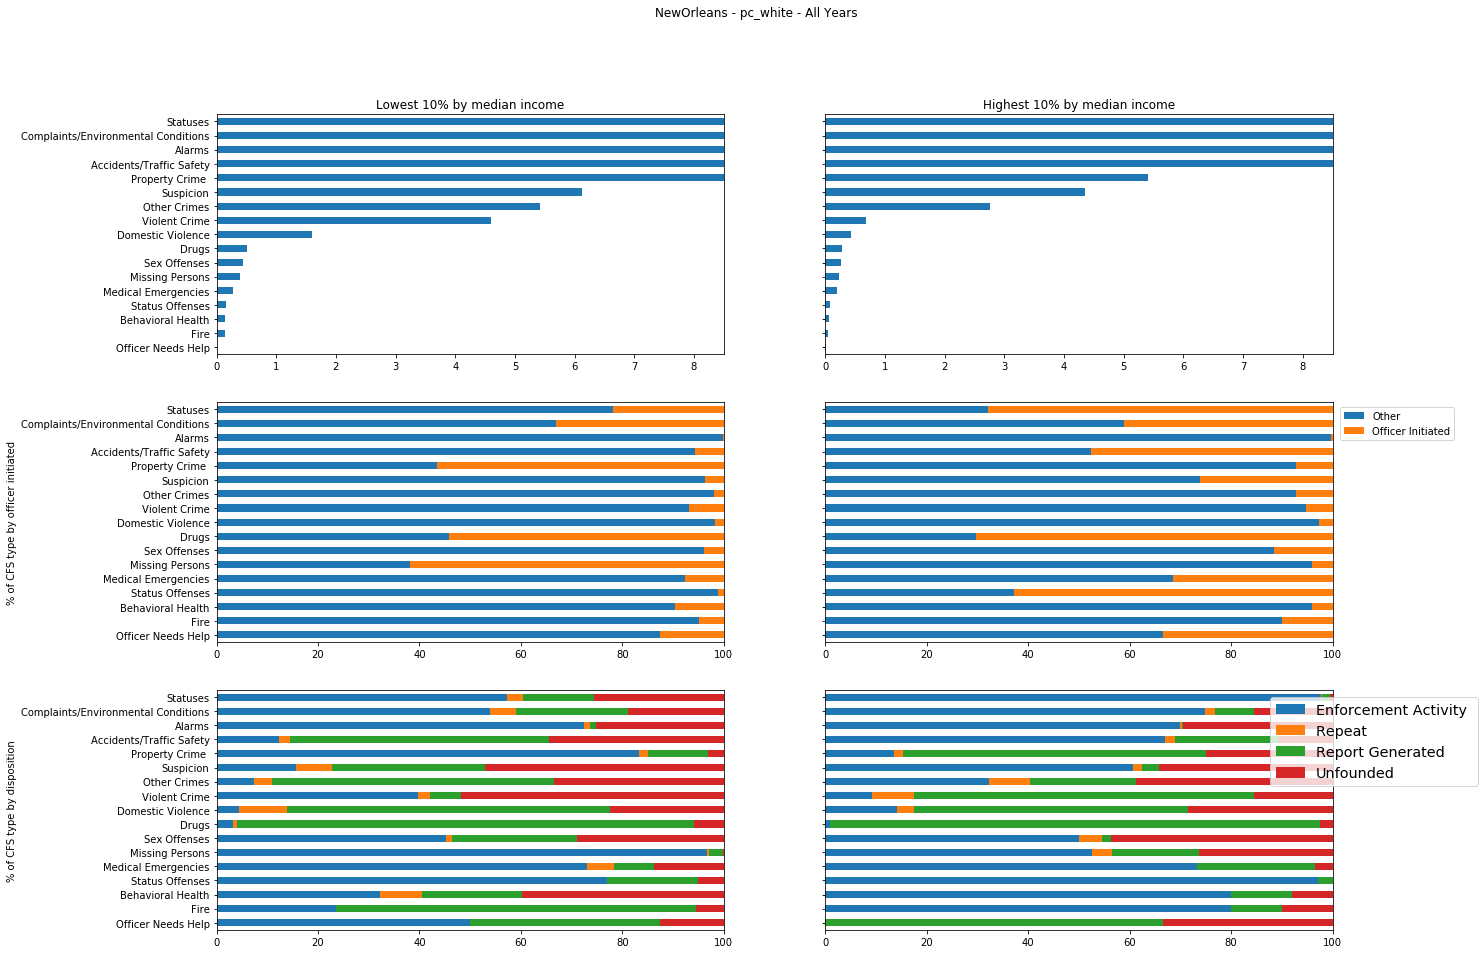

In [61]:
for city in [new_orleans,dallas,detroit,charleston]:
    
    demos = ['pc_white','pc_black','pc_occupied_homes','median_income','median_rent','percent_income_spent_on_rent' ]
    out_dir =  BASE_CHARTS_DIR / 'demographics_comparison'
    out_dir.mkdir(exist_ok=True)
    
    for demo in demos:
        plot_demographic_breakdown_summary(city,demo,out_dir)
        for year in city.USE_YEARS:
            plot_demographic_breakdown_summary(new_orleans,demo,out_dir,year=year)

In [81]:
import numpy as np
import seaborn as sns

In [ ]:
plot_dir = BASE_CHARTS_DIR / 'correlation_coefficients'
plot_dir.mkdir(exist_ok=True)


def make_tract_metrics(city, call_type=None, year=None):
    col_volume  = (city.call_volume_by_tract(norm_by='capita',call_type=call_type, year=year)
                           .dropna()
                           .drop('geometry',axis=1)).rename(columns={'calls':"calls_per_capita_per_year"})
    try:
        enforcement_fraction = city.disposition_by_tract(norm_by='total', call_type=call_type, year=year)[city.ENFORCEMENT_VARIABLES].sum(axis=1)
    except: 
        enforcement_fraction = np.nan 
    
    try:
        officer_initated_fraction = city.self_initated_by_tract(norm_by='total', call_type=call_type, year=year)['Yes']
    except:
        officer_initated_fraction = np.nan
        
    return city.assign_demographics(col_volume.assign(enforcement_fraction = enforcement_fraction, officer_initated_fraction=officer_initated_fraction))


def make_corr_plot_for_city(data, city, cut='All',metrics=['calls_per_capita_per_year', 'enforcement_fraction', 'officer_initated_fraction']):
    demos = ['pc_asian','pc_black','pc_employed', 'pc_hispanic', 'pc_occupied_homes', 'pc_white','median_income', 'median_rent']
    corr_data = data.copy().drop(['state','county','tract','geometry'],axis=1)
    corr_data = corr_data.dropna(axis=1, how='all')
    corr_data[corr_data <0 ] = None
    corr_data = corr_data.dropna(how='any',axis=0)    
    result = []
    for metric in metrics:
        if(metric in corr_data.columns):
            for demo in demos:
                result.append( { 'c': corr_data[metric].corr(corr_data[demo]), 'city' : city, 'metric': metric,'demo':demo})
    return pd.DataFrame(result)

for call_type in new_orleans.clean_data().call_type.unique():
    all_data = pd.DataFrame()

    for city in [new_orleans,detroit,dallas,charleston]:
        tract_data = make_tract_metrics(city, call_type=call_type).set_index('GEOID')
        all_data = all_data.append(make_corr_plot_for_city(tract_data, city.BASE_NAME ))

    # g= sns.PairGrid(all_data, x_vars = ['c','metric','city'], y_vars=['demo'], height=10, aspect=.25)

    plt.figure(figsize=(10,5))

    demo_names =['% Asian', '% Black', '% Hispanic', '% White', '% Employed', 'Median Income', 'Median rent', '% Occupied homes']
    for index, demo in enumerate(['pc_asian','pc_black','pc_hispanic','pc_white','pc_employed', 'median_income', 'median_rent','pc_occupied_homes']):

        plt.subplot(2,4,index+1 )
        ax = sns.stripplot( data=all_data[all_data.demo == demo], x='c',y='metric', hue='city')
        ax.set_xlim(-1,1)
        if(index!=0 and index!=4):
            ax.set_yticklabels([])
        else:
            ax.set_yticklabels(['Calls per capita per year','Enforcement fraction', 'Officer initiated'])
        plt.axvline(x=0)
        if(index == 3):
            plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        else:
            ax.get_legend().remove()
        ax.set_ylabel('')
        ax.set_xlabel('Correlation coefficent')
        plt.title(demo_names[index])
    plt.tight_layout(rect=[0,0.03,1,0.95])
    plt.suptitle(call_type)
    plt.savefig(plot_dir / slugify(call_type))

In [127]:
data = charleston.clean_data()

In [130]:
import geopandas as gp

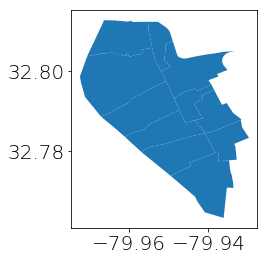

In [149]:
ax =gp.read_file("/home/vera0519/vera_911/data/raw/Charleston/tracts.geojson").plot()

In [153]:
ax.get_ylim()

(32.417257427897425, 33.602802572102568)

In [139]:
from shapely.geometry import Point

In [159]:
cd[cd['LONGITUDE']<0 ]

,Master_Incident_Number,Response_Date,Problem,Address,City,State,Postal_Code,Call_Disposition,Time_CallClosed,LONGITUDE,LATITUDE,geometry
0,201900000003,1/1/2019,911 Open Line,577-593 KING ST,CHARLESTON,SC,29403.0,LCCN_Call Completed/ No Rep,1/1/2019,-79.941120,32.792680,POINT (-79.94112 32.79268)
1,201900000004,1/1/2019,Patrol Request,201-204 CREEK BACK ST,CHARLESTON,SC,29492.0,LPA_Patrol Area,1/1/2019,-79.891741,32.878194,POINT (-79.89174100000001 32.878194)
2,201900000009,1/1/2019,135C_Weapons Shots Heard Wpn,Johnson St / Nassau St,CHARLESTON,SC,29403.0,LCCN_Call Completed/ No Rep,1/1/2019,-79.942146,32.801110,POINT (-79.94214599999999 32.80110999999999)
3,201900000010,1/1/2019,135C_Weapons Shots Heard Wpn,3672 Maybank Hwy,CHARLESTON,SC,29455.0,LCCN_Call Completed/ No Rep,1/1/2019,-80.085195,32.718354,POINT (-80.085195 32.718354)
4,201900000013,1/1/2019,Patrol Request,17-73 IRON BOTTOM LN,CHARLESTON,SC,29492.0,LPA_Patrol Area,1/1/2019,-79.897128,32.880130,POINT (-79.89712800000001 32.88013)
5,201900000016,1/1/2019,113C_Disturbance Loud Party,5954 Savannah Hwy,RAVENEL,SC,29470.0,LCCN_Call Completed/ No Rep,1/1/2019,-80.230537,32.780047,POINT (-80.230537 32.780047)
6,201900000019,1/1/2019,135D_Weapns Shots Fired Seen W,Taberwood Cir / Hazelwood Dr,CHARLESTON,SC,29407.0,LPA_Patrol Area,1/1/2019,-80.022559,32.805033,POINT (-80.022559 32.805033)
7,201900000025,1/1/2019,113O_Disturbance Information,266 Fleming Rd,CHARLESTON,SC,29412.0,LCCN_Call Completed/ No Rep,1/1/2019,-79.982405,32.758157,POINT (-79.982405 32.758157)
8,201900000024,1/1/2019,Traffic Stop,68 Hagood Av,CHARLESTON,SC,29403.0,LW_Written Warning,1/1/2019,-79.957090,32.793601,POINT (-79.95709000000001 32.793601)
9,201900000028,1/1/2019,Traffic Stop,Courtenay Dr / Doughty St,CHARLESTON,SC,29401.0,LW_Written Warning,1/1/2019,-79.951205,32.784053,POINT (-79.951205 32.784053)


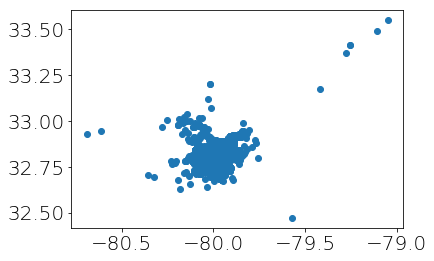

In [160]:
cd = pd.read_csv('/home/vera0519/vera_911/data/raw/Charleston/calls_2019.csv',encoding='latin' )
ax = gp.read_file("/home/vera0519/vera_911/data/raw/Charleston/tracts.geojson").plot()
gcd = gp.GeoDataFrame(cd, geometry= cd.apply(lambda x: Point(x.LONGITUDE, x.LATITUDE),axis=1), crs={"init":"EPSG:4326"})
gcd[gcd.LONGITUDE<0].plot(ax=ax)
